In [1]:
import torch
import torch.nn as nn
from torch.optim import SGD, Adam
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt



In [2]:
train_path = r"data/sign_mnist_train.csv"
test_path = r"data/sign_mnist_test.csv"


In [3]:
class SMDataset(Dataset):
    def __init__(self, file_path):
        data = pd.read_csv(file_path)
        self.y = data["label"]
        self.y = torch.tensor(self.y.values, dtype=torch.long)
        del data["label"]
        # Ensure 1 channel for grayscale images
        self.x = (torch.tensor(data.values, dtype=torch.float) / 255).view(-1, 1, 28, 28)  
    
    def __len__(self):
        return self.x.shape[0]
    
    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]   

In [4]:
train_data = SMDataset(train_path)
test_data = SMDataset(test_path)

# Use batch_size=64 for training DataLoader and batch_size=1 for test DataLoader
train_dl = DataLoader(train_data, batch_size=128, shuffle=True)
test_dl = DataLoader(test_data, batch_size=1)

In [5]:
class SMCNN(nn.Module):
    def __init__(self):
        super(SMCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(32 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 25)
        self.dropout = nn.Dropout(0.005)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)

        x = x.view(-1, 32 * 7 * 7)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)
        return x


In [6]:

def train_model(data, model, n_epochs):
    optimizer = Adam(model.parameters(), lr=0.001)    
    L = nn.CrossEntropyLoss()
    
    losses = []
    epochs = []
    
    for epoch in range(n_epochs):
        print(f"Training epoch {epoch}.")
        for i, (x, y) in enumerate(data):
            optimizer.zero_grad()
            outputs = model(x)
            loss_value = L(outputs, y)
            loss_value.backward()
            optimizer.step()
            epochs.append(epoch + i / len(data))
            losses.append(loss_value.item())
    return np.array(epochs), np.array(losses)


In [7]:

num_epochs = 20

# Create the CNN model
model_cnn = SMCNN()

# Train the CNN model
epoch_data, loss_data = train_model(train_dl, model_cnn, num_epochs)


Training epoch 0.
Training epoch 1.
Training epoch 2.
Training epoch 3.
Training epoch 4.
Training epoch 5.
Training epoch 6.
Training epoch 7.
Training epoch 8.
Training epoch 9.
Training epoch 10.
Training epoch 11.
Training epoch 12.
Training epoch 13.
Training epoch 14.
Training epoch 15.
Training epoch 16.
Training epoch 17.
Training epoch 18.
Training epoch 19.


In [8]:

# Calculate the average loss per epoch
epoch_data_avg = epoch_data.reshape(num_epochs, -1).mean(axis=1)
loss_data_avg = loss_data.reshape(num_epochs, -1).mean(axis=1)


Text(0.5, 1.0, 'Cross Entropy Loss per Epoch')

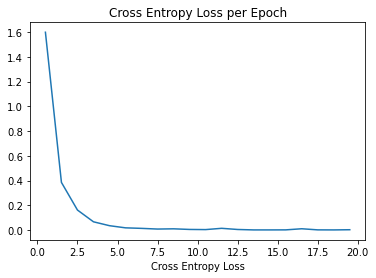

In [9]:

# Plot the training loss
plt.plot(epoch_data_avg, loss_data_avg)
plt.xlabel("Epoch number")
plt.xlabel("Cross Entropy Loss")
plt.title("Cross Entropy Loss per Epoch")



In [10]:
def evaluate_mode(train, test, model):
    x_train, y_train = train_data[:]
    x_test, y_test = test_data[:]
    pred_y_train = model(x_train)
    pred_y_test = model(x_test)
    train_acc = (pred_y_train.argmax(axis=1) == y_train).sum() / len(y_train) * 100
    test_acc = (pred_y_test.argmax(axis=1) == y_test).sum() / len(y_test) * 100
    print("Train set:", len(x_train))
    print("Test set:", len(x_test))
    print(f"Train data accuracy: {train_acc.numpy():.2f}%")
    print(f"Test data accuracy: {test_acc.numpy():.2f}%")
    return train_acc, test_acc

In [11]:
# Evaluate the model on the training and test data
accuracy = evaluate_mode(train_data,test_data, model_cnn)




Train set: 27455
Test set: 7172
Train data accuracy: 99.93%
Test data accuracy: 90.81%
